# Thyroid Cancer Risk Prediction

### Load dataset 

In [22]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



In [23]:
df = pd.read_csv('thyroid_cancer_risk_data.csv')

In [24]:
print("------ df.shape---------")
print(df.shape)

print("------ df.head---------")
print(df.head())

print("----- df.describe--------")
print(df.describe())

print("----- check for null values -----------")
print(df.isnull().sum())

------ df.shape---------
(212691, 17)
------ df.head---------
   Patient_ID  Age  Gender  Country  Ethnicity Family_History  \
0           1   66    Male   Russia  Caucasian             No   
1           2   29    Male  Germany   Hispanic             No   
2           3   86    Male  Nigeria  Caucasian             No   
3           4   75  Female    India      Asian             No   
4           5   35  Female  Germany    African            Yes   

  Radiation_Exposure Iodine_Deficiency Smoking Obesity Diabetes  TSH_Level  \
0                Yes                No      No      No       No       9.37   
1                Yes                No      No      No       No       1.83   
2                 No                No      No      No       No       6.26   
3                 No                No      No      No       No       4.10   
4                Yes                No      No      No       No       9.10   

   T3_Level  T4_Level  Nodule_Size Thyroid_Cancer_Risk Diagnosis  
0      1.67

In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 2: Drop irrelevant columns
df = df.drop(columns=['Patient_ID'])  # Not useful for ML

# Step 3: Standardize object (categorical) columns
# Convert to lowercase and strip spaces for consistency
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.lower().str.strip()

# Optional: Check for unique values per categorical column
# print({col: df[col].unique() for col in df.select_dtypes(include='object').columns})

# Step 4: Encode categorical features
# Label encode binary features or use one-hot encoding for others

# Binary Label Encoding
binary_cols = ['Gender', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 
                'Smoking', 'Obesity', 'Diabetes']

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-Hot Encoding for multi-category features
df = pd.get_dummies(df, columns=['Country', 'Ethnicity', 'Thyroid_Cancer_Risk', 'Diagnosis'], drop_first=True)

# Step 5: Resulting cleaned dataframe
print(df.head())


   Age  Gender  Family_History  Radiation_Exposure  Iodine_Deficiency  \
0   66       1               0                   1                  0   
1   29       1               0                   1                  0   
2   86       1               0                   0                  0   
3   75       0               0                   0                  0   
4   35       0               1                   1                  0   

   Smoking  Obesity  Diabetes  TSH_Level  T3_Level  ...  Country_south korea  \
0        0        0         0       9.37      1.67  ...                False   
1        0        0         0       1.83      1.73  ...                False   
2        0        0         0       6.26      2.59  ...                False   
3        0        0         0       4.10      2.62  ...                False   
4        0        0         0       9.10      2.11  ...                False   

   Country_uk  Country_usa  Ethnicity_asian  Ethnicity_caucasian  \
0       Fals

In [26]:
print(df.columns)

#features
X = df.drop(columns=['Diagnosis_malignant']) 

#label
y = df['Diagnosis_malignant']

print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)

Index(['Age', 'Gender', 'Family_History', 'Radiation_Exposure',
       'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes', 'TSH_Level',
       'T3_Level', 'T4_Level', 'Nodule_Size', 'Country_china',
       'Country_germany', 'Country_india', 'Country_japan', 'Country_nigeria',
       'Country_russia', 'Country_south korea', 'Country_uk', 'Country_usa',
       'Ethnicity_asian', 'Ethnicity_caucasian', 'Ethnicity_hispanic',
       'Ethnicity_middle eastern', 'Thyroid_Cancer_Risk_low',
       'Thyroid_Cancer_Risk_medium', 'Diagnosis_malignant'],
      dtype='object')
Feature matrix shape: (212691, 27)
Label vector shape: (212691,)


In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Random Forest

my_RandomForest = RandomForestClassifier(n_estimators = 29, bootstrap = True, random_state=2)

# fitting the model to the training data
my_RandomForest.fit(X_train, y_train)

# make predictions on the testing set
y_predict_rf = my_RandomForest.predict(X_test)

#get the accuracy score and print
rf_accuracy = accuracy_score(y_test, y_predict_rf)
print('Decision Tree Accuracy:', rf_accuracy)


#AUC

#estimating the probability of each label 
y_predict_prob_rf = my_RandomForest.predict_proba(X_test)

# estimated likelihood of label=1 for the testing set
y_prob_rf = y_predict_prob_rf[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, y_prob_rf, pos_label=1)

AUC_rf = metrics.auc(fpr_rf, tpr_rf)
print('Area Under Curve for ROC', AUC_rf)

Decision Tree Accuracy: 0.8229062186559679
Area Under Curve for ROC 0.694373323300126


In [29]:
# Decision Tree

my_DecisionTree = DecisionTreeClassifier(random_state=2)

# fitting the model to the training data
my_DecisionTree.fit(X_train, y_train)

# make predictions on the testing set
y_predict_dt = my_DecisionTree.predict(X_test)

#get the accuracy score and print
dt_accuracy = accuracy_score(y_test, y_predict_dt)
print('Decision Tree Accuracy:', dt_accuracy)

#AUC 

#estimating the probability of each label 
y_predict_prob_dt = my_DecisionTree.predict_proba(X_test)

# estimated likelihood of label=1 for the testing set
y_prob = y_predict_prob_dt[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, y_prob, pos_label=1)

AUC_dt = metrics.auc(fpr_dt, tpr_dt)
print('Area Under Curve for ROC', AUC_dt)

Decision Tree Accuracy: 0.7049429538615848
Area Under Curve for ROC 0.6013847774412517


In [30]:
# AdaBoost

my_AdaBoost = AdaBoostClassifier(n_estimators = 29,random_state=2)

# fitting the model to the training data
my_AdaBoost.fit(X_train, y_train)

# make predictions on the testing set
y_predict_ab = my_AdaBoost.predict(X_test)

#get the accuracy score and print
ab_accuracy = accuracy_score(y_test, y_predict_ab)
print('Adaboost Accuracy:', ab_accuracy)


# AUC

#estimating the probability of each label 
y_predict_prob_ab = my_AdaBoost.predict_proba(X_test)

# estimated likelihood of label=1 for the testing set
y_prob_ab = y_predict_prob_ab[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_ab, tpr_ab, thresholds_ab = metrics.roc_curve(y_test, y_prob_ab, pos_label=1)

AUC_ab = metrics.auc(fpr_ab, tpr_ab)
print('Area Under Curve for ROC', AUC_ab)

Adaboost Accuracy: 0.8260092778335005
Area Under Curve for ROC 0.6971085490475853


In [31]:
# XGBoost

my_XGBoost = XGBClassifier(n_estimators = 29,random_state=2)

# fitting the model to the training data
my_XGBoost.fit(X_train, y_train)

# make predictions on the testing set
y_predict_xg = my_XGBoost.predict(X_test)

#get the accuracy score and print
xg_accuracy = accuracy_score(y_test, y_predict_xg)
print('XGBoost Accuracy:', xg_accuracy)


# AUC

#estimating the probability of each label 
y_predict_prob_xg = my_XGBoost.predict_proba(X_test)

# estimated likelihood of label=1 for the testing set
y_prob_xg = y_predict_prob_xg[:, 1] 

#false positive rate (fpr) and true positive rate (tpr)
fpr_xg, tpr_xg, thresholds_xg = metrics.roc_curve(y_test, y_prob_xg, pos_label=1)

AUC_xg = metrics.auc(fpr_xg, tpr_xg)
print('Area Under Curve for ROC', AUC_xg)

XGBoost Accuracy: 0.8257898696088265
Area Under Curve for ROC 0.6928483952208633


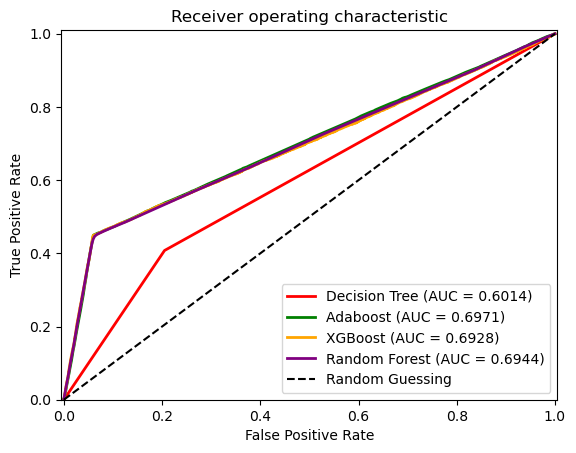

In [32]:
%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label='Decision Tree (AUC = %0.4f)' % AUC_dt)
plt.plot(fpr_ab, tpr_ab, color='green', lw=2, label='Adaboost (AUC = %0.4f)' % AUC_ab)
plt.plot(fpr_xg, tpr_xg,color='orange', lw=2, label='XGBoost (AUC = %0.4f)' % AUC_xg)
plt.plot(fpr_rf, tpr_rf,color='purple', lw=2, label='Random Forest (AUC = %0.4f)' % AUC_rf)

# Random Guess line:
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()